# DC2 Sprinkler Validation Tests for Lensed SNe

The most recent Sprinkler Truth Catalogs are in `/global/cscratch1/sd/brycek/example_truth`.

Unlensed SNe population are in: `/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db`

In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In [2]:
from lsst.sims.catUtils.supernovae    import SNObject
from lsst.sims.photUtils.BandpassDict import BandpassDict, Bandpass
from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.SedUtils import getImsimFluxNorm

In [3]:
import lsst

## Lensed SNe validation tests

#### Load necessary files

Unlensed SNe population files are in: `/global/cfs/cdirs/descssim/DC2/cosmoDC2_v1.1.4/` with filenames starting with `sne_cosmoDC2_v1.1.4*`

In [4]:
cosmoDC2_base = '/global/cfs/cdirs/descssim/DC2/cosmoDC2_v1.1.4/'

In [5]:
conn  = sqlite3.connect(os.path.join(cosmoDC2_base, 'sne_cosmoDC2_v1.1.4_MS_DDF.db'))
query = "SELECT * FROM sne_params;"

# Unlensed SNe
unlensed_sne_df = pd.read_sql_query(query,conn)

In [6]:
example_truth_folder = '/global/cfs/cdirs/descssim/DC2/Run3.0i/truth_tables/'
conn = sqlite3.connect(os.path.join(example_truth_folder, 'updated_lensed_sne_truth.db'))

# Pick only the first image of each SN so we don't have duplicate entries of the same SNe
#query = "SELECT * FROM lensed_sne WHERE image_number == 0;"
query = "SELECT * FROM lensed_sne"

# DDF unlensed SNe
sprinkled_sne_df = pd.read_sql_query(query,conn)

### Input SNe catalog

In [7]:
sn_catalog_sys = pd.read_hdf('/global/cfs/cdirs/descssim/DC2/Run3.0i/sprinkler_dc2_data/glsne_dc2_v2.h5', key='system')
sn_catalog_img = pd.read_hdf('/global/cfs/cdirs/descssim/DC2/Run3.0i/sprinkler_dc2_data/glsne_dc2_v2.h5', key='image')

In [8]:
# Checking the file to see what keys are available
with pd.HDFStore('/global/cfs/cdirs/descssim/DC2/Run3.0i/sprinkler_dc2_data/glsne_dc2_v2.h5') as hdf:
    print(hdf.keys())

Opening /global/cfs/cdirs/descssim/DC2/Run3.0i/sprinkler_dc2_data/glsne_dc2_v2.h5 in read-only mode
['/image', '/system', '/system/meta/values_block_2/meta', '/system/meta/values_block_1/meta', '/system/meta/values_block_0/meta']


In [9]:
sn_catalog_sys.head()

,t0,sigma,gamma,e,theta_e,theta_gamma,zs,zl,snx,sny,...,lensgal_n,lensgal_ellip,lensgal_reff,lensgal_theta,lensgal_amplitude,lensgal_type,lensgal_x,lensgal_y,t_found,lensgal_mi
0,62307.945863,197.670149,0.128101,0.570391,132.165475,135.210348,0.435736,0.152485,-0.136216,0.144903,...,4.0,0.570391,1.873893,132.165475,3.183900e-16,kinney-elliptical,0.0,0.0,62309.959876,17.063607
0,62986.222880,270.972759,0.040137,0.785929,349.848750,76.941654,0.812597,0.106528,0.229110,-0.578431,...,4.0,0.785929,1.104613,349.848750,3.887914e-16,kinney-elliptical,0.0,0.0,63001.066591,16.819399
0,60175.070270,168.759862,0.145709,0.704465,246.352212,103.154255,0.377906,0.036807,0.074938,-0.416329,...,4.0,0.704465,4.012286,246.352212,5.997613e-15,kinney-elliptical,0.0,0.0,60180.306487,13.786878
0,59748.557028,132.459490,0.017375,0.598633,58.483556,133.326378,0.760426,0.034289,0.012960,0.362303,...,4.0,0.598633,3.339015,58.483556,1.514571e-15,kinney-elliptical,0.0,0.0,59753.360582,15.279224
0,61949.847395,118.022925,0.040725,0.593290,160.205181,318.665928,0.608011,0.062039,0.052200,0.120958,...,4.0,0.593290,1.992299,160.205181,4.322670e-16,kinney-elliptical,0.0,0.0,61964.966613,16.656477


In [10]:
sn_catalog_sys.columns

Index(['t0', 'sigma', 'gamma', 'e', 'theta_e', 'theta_gamma', 'zs', 'zl',
       'snx', 'sny', 'MB', 'transient_amplitude', 'sysno', 'sntype', 'ebvhost',
       'ra', 'dec', 'ebvmw', 'weight', 'host_n', 'host_ellip', 'host_reff',
       'host_theta', 'host_amplitude', 'host_type', 'host_x', 'host_y',
       'lensgal_n', 'lensgal_ellip', 'lensgal_reff', 'lensgal_theta',
       'lensgal_amplitude', 'lensgal_type', 'lensgal_x', 'lensgal_y',
       't_found', 'lensgal_mi'],
      dtype='object')

In [11]:
sn_catalog_img.head()

,td,x,y,mu,sysno,imno
0,0.000000,-0.756175,0.795804,1.618521,2237,0
1,11.548608,-0.216867,-0.435236,-1.057005,2237,1
2,10.111286,0.439743,-0.467307,2.794231,2237,2
3,11.585389,0.449632,0.186466,-1.024824,2237,3
0,0.000000,1.856731,-1.243184,1.709018,61544,0


### SN Population Comparison

In [12]:
unlensed_sne_df.head()

,htmid_level_6,galaxy_id,c_in,mB,t0_in,x0_in,x1_in,z_in,snid_in,snra_in,sndec_in
0,9021,10562502111,0.035201,18.516489,60772.368515,0.000617,1.477374,0.077278,MS_10199_0,66.115587,-40.866055
1,9023,10562500822,-0.086665,17.966773,63060.297448,0.001028,0.576378,0.073256,MS_10199_1,66.662435,-42.042877
2,9021,10562500735,0.037553,19.078334,62832.166508,0.000370,-0.177457,0.068469,MS_10199_2,65.212146,-41.416473
3,9021,10562502246,0.076715,19.192019,61400.008116,0.000335,-1.344205,0.080189,MS_10199_3,65.469824,-41.109646
4,9023,10562504918,-0.012653,19.388848,61342.657248,0.000278,0.474204,0.115499,MS_10199_5,65.986211,-42.086708


In [13]:
sprinkled_sne_df.head()

,index,unique_id,gal_unq_id,ra,dec,x_sne,y_sne,x_img,y_img,t0,...,c,host_type,redshift,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification
0,0,GLSNE_0_0,GLSNE_sne_0_0,53.535516,-28.075830,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,0,13.704318
1,0,GLSNE_0_1,GLSNE_sne_0_0,53.535573,-28.075818,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,1,13.704318
2,0,GLSNE_0_2,GLSNE_sne_0_0,53.535589,-28.075739,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,2,13.704318
3,0,GLSNE_0_3,GLSNE_sne_0_0,53.535429,-28.075699,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,3,13.704318
4,4,GLSNE_1_0,GLSNE_sne_1_0,52.835880,-27.813210,0.035717,-0.022968,0.023081,-0.16193,61816.678369,...,0.0,kinney-sc,0.658430,0.024149,3.1,1.875368e+09,GLSNE_1,91135,0,8.847192


## Checking distribution of SN parameters in the next few blocks

#### $x_0$ distribution

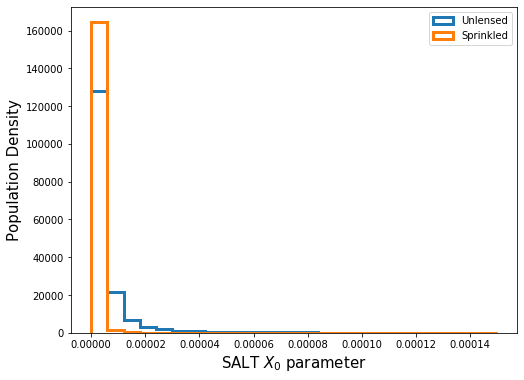

In [14]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['x0_in'], bins=25, range=(0.0, 0.00015), lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['x0'], bins=bins, lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $X_0$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### $x_1$ distribution

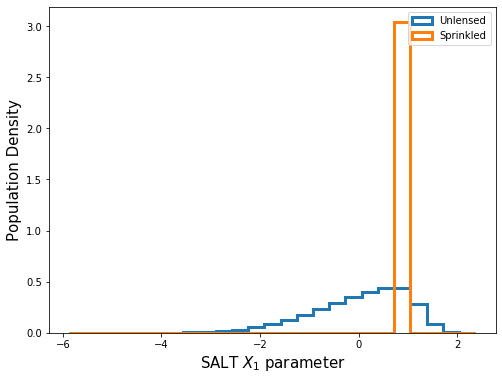

In [15]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['x1_in'], bins=25, lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['x1'], bins=bins, lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $X_1$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### $c$ distribution

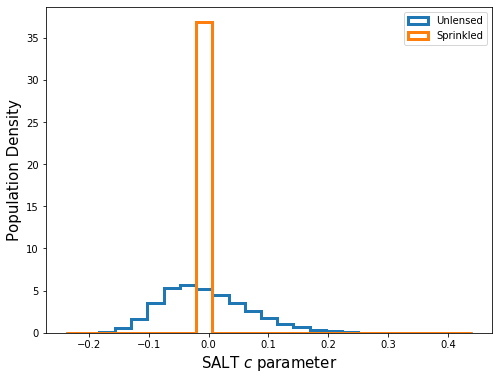

In [16]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['c_in'], bins=25,  lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['c'],   bins=bins,lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $c$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### Comparing $M_B$ of SN catalog with simulated SN

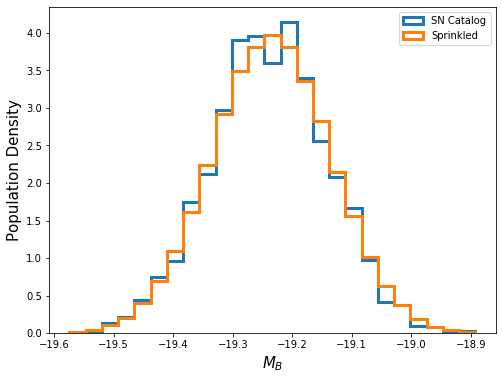

In [17]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['MB'], bins=25,  lw=3, histtype='step', density=True, label='SN Catalog')
_          = plt.hist(sn_catalog_sys['MB'],   bins=bins,lw=3, histtype='step', density=True, label='Sprinkled')
#_          = plt.hist(unlensed_sne_df['mB'],  bins=bins,lw=3, histtype='step', density=True, label='Unlensed')
plt.xlabel('$M_B$', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### All the SNe have $x_1$ = 1 and $c=0$

In [18]:
np.where(sprinkled_sne_df['c'] != 0)

(array([], dtype=int64),)

In [19]:
np.where(sprinkled_sne_df['x1'] != 1)

(array([], dtype=int64),)

### Check distribution of angular separations, magnification, time delay

In [20]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [21]:
sprinkled_sne_df.head()

,index,unique_id,gal_unq_id,ra,dec,x_sne,y_sne,x_img,y_img,t0,...,c,host_type,redshift,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification
0,0,GLSNE_0_0,GLSNE_sne_0_0,53.535516,-28.075830,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,0,13.704318
1,0,GLSNE_0_1,GLSNE_sne_0_0,53.535573,-28.075818,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,1,13.704318
2,0,GLSNE_0_2,GLSNE_sne_0_0,53.535589,-28.075739,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,2,13.704318
3,0,GLSNE_0_3,GLSNE_sne_0_0,53.535429,-28.075699,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,3,13.704318
4,4,GLSNE_1_0,GLSNE_sne_1_0,52.835880,-27.813210,0.035717,-0.022968,0.023081,-0.16193,61816.678369,...,0.0,kinney-sc,0.658430,0.024149,3.1,1.875368e+09,GLSNE_1,91135,0,8.847192


In [22]:
sysidlist = np.unique(sprinkled_sne_df['lens_cat_sys_id'])
indices_by_system = np.array([np.where(sprinkled_sne_df['lens_cat_sys_id']==sysid)[0] for sysid in sysidlist])

In [23]:
lensedSN_coordinates = SkyCoord(ra=sprinkled_sne_df['ra']*u.degree, dec=sprinkled_sne_df['dec']*u.degree, frame='icrs')
lensedSN_sep_arcsec = []
for idxlist in indices_by_system:
    coords_this_sys = lensedSN_coordinates[idxlist]
    separations_this_sys = coords_this_sys[0].separation(coords_this_sys).to(u.arcsecond)
    lensedSN_sep_arcsec += (separations_this_sys.value).tolist()
lensedSN_sep_arcsec = np.array(lensedSN_sep_arcsec).flatten()
lensedSN_sep_arcsec_nonzero = lensedSN_sep_arcsec[np.nonzero(lensedSN_sep_arcsec>0)[0]]

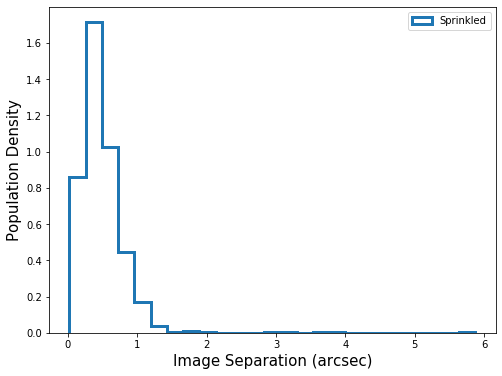

In [24]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(lensedSN_sep_arcsec_nonzero, bins=25,  lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('Image Separation (arcsec)', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

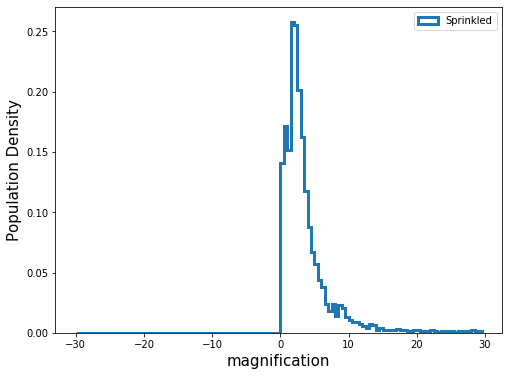

In [25]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['magnification'], bins=np.arange(-30,30,0.5),  lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('magnification', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

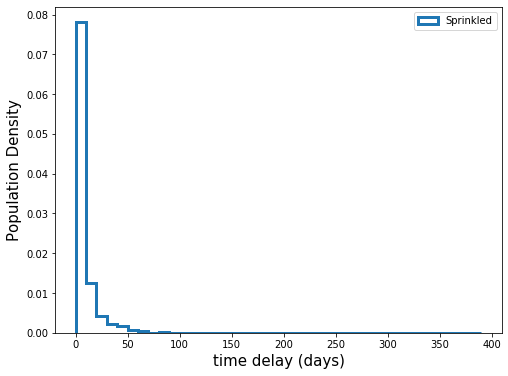

In [26]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['t_delay'], bins=np.arange(0.01,400,10), lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('time delay (days)', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

(0.01, 500)

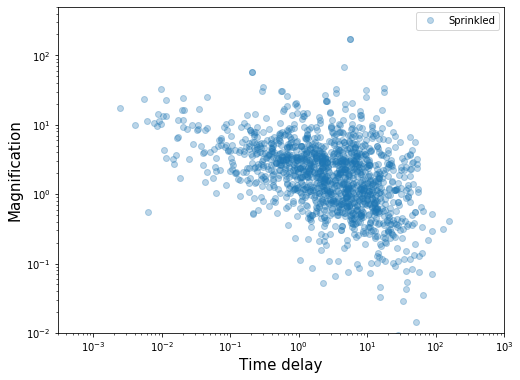

In [27]:
fig        = plt.figure(figsize=(8, 6))
#plt.plot(lensedSN_sep_arcsec, sprinkled_sne_df['magnification'],  ls=' ', marker='o', alpha=0.3, label='Sprinkled')
plt.loglog(sprinkled_sne_df['t_delay'], np.abs(sprinkled_sne_df['magnification']),  ls=' ', marker='o', alpha=0.3, label='Sprinkled')

plt.xlabel('Time delay', fontsize=15)
plt.ylabel('Magnification',   fontsize=15)
plt.legend(loc='best')

ax = plt.gca()
ax.set_xlim(3e-4, 1000)
ax.set_ylim(0.01, 500)

## Check that the input magnifications and time delays match the sprinkled values

### Checking instance catalog values

In [28]:
sne_cat_dir = '/global/cscratch1/sd/brycek/test_sprinkler_instance_catalogs/test_sprinkler_sne_ics'

In [148]:
full_df = pd.DataFrame([], columns=['obj_id', 'ra', 'dec', 'magnorm', 'sed', 'redshift', 'time'])
for cat_file in os.listdir(sne_cat_dir):
    if cat_file.startswith('test_cat') is False:
        continue
        
    time = float(cat_file.split('_')[2])
    cat_data = pd.read_csv(os.path.join(sne_cat_dir, cat_file), delimiter=' ', usecols=[1,2,3,4,5,6],
                           names=['obj_id', 'ra', 'dec', 'magnorm', 'sed', 'redshift'])
    cat_data['time'] = time
    full_df = full_df.append(cat_data)

In [149]:
full_df = full_df.reset_index(drop=True)

In [150]:
im_0 = full_df.query('obj_id == "GLSNE_639_0"')
im_1 = full_df.query('obj_id == "GLSNE_639_1"')
im_2 = full_df.query('obj_id == "GLSNE_639_2"')
im_3 = full_df.query('obj_id == "GLSNE_639_3"')

In [151]:
# im_0 = full_df.query('obj_id == "GLSNE_1085_0"')
# im_1 = full_df.query('obj_id == "GLSNE_1085_1"')
# im_2 = full_df.query('obj_id == "GLSNE_1085_2"')
# im_3 = full_df.query('obj_id == "GLSNE_1085_3"')

In [152]:
im_0

,obj_id,ra,dec,magnorm,sed,redshift,time
8,GLSNE_639_0,52.779495,-27.558778,24.631941,sne_sed/specFileGLSN_GLSNE_639_0_59610.8896.tx...,1.28882,59610.8896
37,GLSNE_639_0,52.779495,-27.558778,24.352734,sne_sed/specFileGLSN_GLSNE_639_0_59583.6396.tx...,1.28882,59583.6396
64,GLSNE_639_0,52.779495,-27.558778,24.620030,sne_sed/specFileGLSN_GLSNE_639_0_59610.6396.tx...,1.28882,59610.6396
93,GLSNE_639_0,52.779495,-27.558778,24.344297,sne_sed/specFileGLSN_GLSNE_639_0_59584.1396.tx...,1.28882,59584.1396
119,GLSNE_639_0,52.779495,-27.558778,24.342361,sne_sed/specFileGLSN_GLSNE_639_0_59600.1396.tx...,1.28882,59600.1396
...,...,...,...,...,...,...,...
3946,GLSNE_639_0,52.779495,-27.558778,24.371670,sne_sed/specFileGLSN_GLSNE_639_0_59582.6396.tx...,1.28882,59582.6396
3971,GLSNE_639_0,52.779495,-27.558778,24.333779,sne_sed/specFileGLSN_GLSNE_639_0_59598.8896.tx...,1.28882,59598.8896
3998,GLSNE_639_0,52.779495,-27.558778,24.393460,sne_sed/specFileGLSN_GLSNE_639_0_59581.6396.tx...,1.28882,59581.6396
4022,GLSNE_639_0,52.779495,-27.558778,24.330362,sne_sed/specFileGLSN_GLSNE_639_0_59598.3896.tx...,1.28882,59598.3896


In [153]:
np.unique(full_df['obj_id'])

array(['GLSNE_1011_0', 'GLSNE_1011_1', 'GLSNE_1011_2', 'GLSNE_1011_3',
       'GLSNE_1066_0', 'GLSNE_1066_1', 'GLSNE_1085_0', 'GLSNE_1085_1',
       'GLSNE_1085_2', 'GLSNE_1085_3', 'GLSNE_1128_0', 'GLSNE_1128_1',
       'GLSNE_1128_2', 'GLSNE_1128_3', 'GLSNE_23_0', 'GLSNE_23_1',
       'GLSNE_23_2', 'GLSNE_23_3', 'GLSNE_282_0', 'GLSNE_282_1',
       'GLSNE_282_2', 'GLSNE_282_3', 'GLSNE_299_0', 'GLSNE_299_1',
       'GLSNE_299_2', 'GLSNE_639_0', 'GLSNE_639_1', 'GLSNE_639_2',
       'GLSNE_639_3', 'GLSNE_686_0', 'GLSNE_686_1', 'GLSNE_686_2',
       'GLSNE_686_3', 'GLSNE_735_0', 'GLSNE_735_1', 'GLSNE_735_3',
       'GLSNE_768_0', 'GLSNE_768_1', 'GLSNE_768_2', 'GLSNE_790_0'],
      dtype=object)

In [154]:
sprinkled_sne_df.head()

,index,unique_id,gal_unq_id,ra,dec,x_sne,y_sne,x_img,y_img,t0,...,c,host_type,redshift,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification
0,0,GLSNE_0_0,GLSNE_sne_0_0,53.535516,-28.075830,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,0,13.704318
1,0,GLSNE_0_1,GLSNE_sne_0_0,53.535573,-28.075818,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,1,13.704318
2,0,GLSNE_0_2,GLSNE_sne_0_0,53.535589,-28.075739,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,2,13.704318
3,0,GLSNE_0_3,GLSNE_sne_0_0,53.535429,-28.075699,-0.062063,0.039200,-0.309583,0.23567,59758.905037,...,0.0,kinney-elliptical,0.883446,0.021971,3.1,2.562562e+09,GLSNE_0,81692,3,13.704318
4,4,GLSNE_1_0,GLSNE_sne_1_0,52.835880,-27.813210,0.035717,-0.022968,0.023081,-0.16193,61816.678369,...,0.0,kinney-sc,0.658430,0.024149,3.1,1.875368e+09,GLSNE_1,91135,0,8.847192


In [155]:
sys_truth = sprinkled_sne_df.query('dc2_sys_id == "GLSNE_639"')

In [156]:
# sys_truth = sprinkled_sne_df.query('dc2_sys_id == "GLSNE_1085"')

In [157]:
sys_truth

,index,unique_id,gal_unq_id,ra,dec,x_sne,y_sne,x_img,y_img,t0,...,c,host_type,redshift,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number,total_magnification
2061,2006,GLSNE_639_0,GLSNE_sne_639_0,52.779832,-27.559284,-0.00245,0.006678,-0.139515,-0.054657,59592.503471,...,0.0,kinney-sc,1.28882,0.031222,3.1,1.875856e+09,GLSNE_639,4114756,0,13.169406
2062,2006,GLSNE_639_1,GLSNE_sne_639_0,52.779780,-27.559255,-0.00245,0.006678,-0.139515,-0.054657,59592.503471,...,0.0,kinney-sc,1.28882,0.031222,3.1,1.875856e+09,GLSNE_639,4114756,1,13.169406
2063,2006,GLSNE_639_2,GLSNE_sne_639_0,52.779863,-27.559237,-0.00245,0.006678,-0.139515,-0.054657,59592.503471,...,0.0,kinney-sc,1.28882,0.031222,3.1,1.875856e+09,GLSNE_639,4114756,2,13.169406
2064,2006,GLSNE_639_3,GLSNE_sne_639_0,52.779805,-27.559194,-0.00245,0.006678,-0.139515,-0.054657,59592.503471,...,0.0,kinney-sc,1.28882,0.031222,3.1,1.875856e+09,GLSNE_639,4114756,3,13.169406


In [158]:
sys_truth[['magnification', 't_delay']]

,magnification,t_delay
2061,4.397841,0.000000
2062,2.738947,0.507575
2063,2.610280,0.550705
2064,3.422339,-0.488937


In [159]:
-2.5*np.log10(np.abs(sys_truth['magnification']))

2061   -1.608099
2062   -1.093959
2063   -1.041718
2064   -1.335807
Name: magnification, dtype: float64

In [160]:
imSimBand = Bandpass()
imSimBand.imsimBandpass()

In [161]:
def make_sn_model_lightcurve(ra , dec , redshift, t0, x0, x1, c, StartTime, EndTime, band, n):
    '''
    StartTime: could be t0-5 days (depending on redshift)
    EndTime: could be t0+40 days
    band: LSST filter
    n: number of points wanted for the time array
    '''        
    
    imSimBand = Bandpass()
    imSimBand.imsimBandpass()
    
    # Setting up the supernova with the light-curve parameters from Sprinkled catalog
    sn_mod = SNObject(ra = ra, dec = dec)   
    sn_mod.set(z  = redshift,  t0 = t0, x0 = x0, x1 = x1, c  = c)

    # create a time array
    time_array = np.linspace(StartTime, EndTime, n)
    flux_array = []
    mag_array = []
    
    # Get SED
    for time in time_array:
        SEDfromSNcosmo = sn_mod.SNObjectSourceSED(time=time, wavelen=np.arange(30., 1800., 0.1))
        flux = SEDfromSNcosmo.calcFlux(bandpass=imSimBand) / 3631.0
        flux_array.append(flux)
        mag_array.append(-2.5*np.log10(flux))
        
    
    flux_array = np.array(flux_array)
    mag_array  = np.array(mag_array)
    print(np.max(flux_array))
        
    return time_array, flux_array, mag_array#, sn_mod

In [162]:
im_num = 0
t_s = 59580.1396
t_e = 59613.1396
t_a, f_a, m_a = make_sn_model_lightcurve(sys_truth.iloc[im_num]['ra'],
                                     sys_truth.iloc[im_num]['dec'],
                                     sys_truth.iloc[im_num]['redshift'],
                                     sys_truth.iloc[im_num]['t0'] - sys_truth.iloc[im_num]['t_delay'],
                                     sys_truth.iloc[im_num]['x0'],
                                     sys_truth.iloc[im_num]['x1'],
                                     sys_truth.iloc[im_num]['c'],
                                     t_s, t_e, 'r', (t_e - t_s) * 4.)

4.3673542717284426e-11


(array([25.8, 25.9, 26. , 26.1, 26.2, 26.3, 26.4, 26.5]),
 <a list of 8 Text yticklabel objects>)

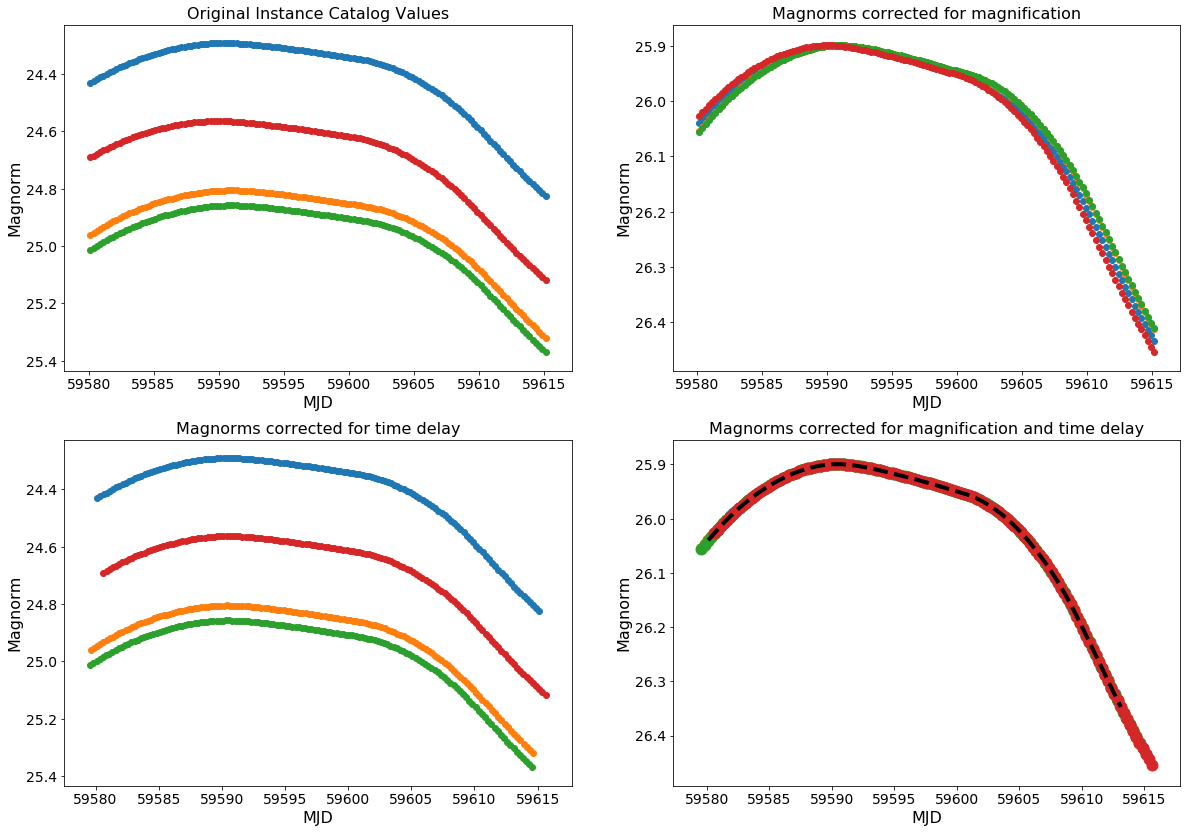

In [163]:
fig = plt.figure(figsize=(20, 14))
fig.add_subplot(2,2,1)
plt.scatter(im_0['time'], im_0['magnorm'])
plt.scatter(im_1['time'], im_1['magnorm'])
plt.scatter(im_2['time'], im_2['magnorm'])
plt.scatter(im_3['time'], im_3['magnorm'])
plt.xlabel('MJD', size=16)
plt.ylabel('Magnorm', size=16)
plt.gca().invert_yaxis()
plt.title('Original Instance Catalog Values', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,2)
plt.scatter(im_0['time'], im_0['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[0]))
plt.scatter(im_1['time'], im_1['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[1]))
plt.scatter(im_2['time'], im_2['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[2]))
plt.scatter(im_3['time'], im_3['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[3]))
plt.xlabel('MJD', size=16)
plt.ylabel('Magnorm', size=16)
plt.gca().invert_yaxis()
plt.title('Magnorms corrected for magnification', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,3)
plt.scatter(im_0['time'] - sys_truth['t_delay'].iloc[0], im_0['magnorm'])
plt.scatter(im_1['time'] - sys_truth['t_delay'].iloc[1], im_1['magnorm'])
plt.scatter(im_2['time'] - sys_truth['t_delay'].iloc[2], im_2['magnorm'])
plt.scatter(im_3['time'] - sys_truth['t_delay'].iloc[3], im_3['magnorm'])
plt.xlabel('MJD', size=16)
plt.ylabel('Magnorm', size=16)
plt.gca().invert_yaxis()
plt.title('Magnorms corrected for time delay', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,4)
plt.scatter(im_0['time'] - sys_truth['t_delay'].iloc[0], im_0['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[0]), s=120)
plt.scatter(im_1['time'] - sys_truth['t_delay'].iloc[1], im_1['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[1]), s=120)
plt.scatter(im_2['time'] - sys_truth['t_delay'].iloc[2], im_2['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[2]), s=120)
plt.scatter(im_3['time'] - sys_truth['t_delay'].iloc[3], im_3['magnorm']+2.5*np.log10(np.abs(sys_truth['magnification']).iloc[3]), s=120)
plt.plot(t_a, m_a, lw=4, c='k', ls='--')
plt.xlabel('MJD', size=16)
plt.ylabel('Magnorm', size=16)
plt.gca().invert_yaxis()
plt.title('Magnorms corrected for magnification and time delay', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

In [164]:
def calc_r_band_photometry(sed_filename, sed_redshift, bandpass_dict, magnorm_value):
    
    if not os.path.exists(sed_filename):
        print('no')
        
    sed_data = np.genfromtxt(sed_filename)
    
    sne_sed = Sed()
    sne_sed.readSED_flambda(sed_filename, cache_sed=False)
    fluxNorm = getImsimFluxNorm(sne_sed, magnorm_value)
    sne_sed.multiplyFluxNorm(fluxNorm)
    sne_sed.redshiftSED(sed_redshift, dimming=True)
    mag = sne_sed.calcMag(bandpass_dict['r'])
    
    test_sed = Sed()
    test_sed.readSED_flambda(sed_filename)
    
    return mag, sne_sed, test_sed
#    return test_sed, sed_filename
    

### Matching time-delayed SNe light-curves with the original light-curves after phase shift and de-magnification

We match the sn_catalog_img to the sprinkled_sne_df using the sysno and lens_cat_sys_id keys

In [165]:
LSST_BPass = BandpassDict.loadTotalBandpassesFromFiles()

In [166]:
def make_sn_model_lightcurve(ra , dec , redshift, t0, x0, x1, c, StartTime, EndTime, band, n):
    '''
    StartTime: could be t0-5 days (depending on redshift)
    EndTime: could be t0+40 days
    band: LSST filter
    n: number of points wanted for the time array
    '''        
    # Setting up the supernova with the light-curve parameters from Sprinkled catalog
    sn_mod = SNObject(ra = ra, dec = dec)   
    sn_mod.set(z  = redshift,  t0 = t0, x0 = x0, x1 = x1, c  = c)

    # create a time array
    time_array = np.linspace(StartTime, EndTime, n)
    flux_array = np.array([sn_mod.catsimBandFlux(mjd, LSST_BPass[band]) for mjd in time_array])
    mag_array  = np.array([sn_mod.catsimBandMag(LSST_BPass[band], mjd, noNan=True) for mjd in time_array])
        
    return time_array, flux_array, mag_array

In [173]:
def plot_lensedSN_composite_lightcurve_model(lens_cat_sys_id, sprinkled_source_catalog, 
                                             lens_properties_catalog, plot_flux=True, **kwargs):
    """ Plot the composite light curve model of a multiply-imaged SN system, overlaying light curves  
    from all images.  Shows the model SN light curve for each image using input lensing parameters 
    (i.e. with the time  delay and magnification that we think were used to simulate the SN), and then 
    the phase-shifted and de-amplified model (after removing the time delay and amplification effects).

    FUTURE WORK NEEDED:  compare this model light curve with recovered photometry to validate that the 
    simulated lensed SNe are in fact including the time delay and amplification correctly. 

    INPUTS:
    lens_cat_sys_id  :  int; the unique identifier for this lensed SN system
    sprinkled_source_catalog : catalog (Table object) that has simulated SN properties (x1, c, t0, z, etc)
    lens_properties_catalog  : catalog (Table) that has the simulated lensing parameters (td, mu)
    """
    # Find the indices in the sprinkled_source_catalog and input_sn_catalog that belong to this lensed SN
    indices_sprinkled_cat = np.where(sprinkled_source_catalog['lens_cat_sys_id']==lens_cat_sys_id)[0]
    indices_lens_cat = np.where(lens_properties_catalog['sysno']==lens_cat_sys_id)[0]
    n_sn_images = 2 # len(indices_lens_cat)
    assert len(indices_lens_cat) == len(indices_sprinkled_cat)
    
    fig = plt.figure(figsize=[10,5])    
    axlist= [fig.add_subplot(1,n_sn_images+1,i+1) for i in range(n_sn_images)]
    axfinal = fig.add_subplot(1,n_sn_images+1, n_sn_images+1)
    
    sprinkle_subcat = sprinkled_source_catalog.iloc[indices_sprinkled_cat]
    lens_subcat = lens_properties_catalog.iloc[indices_lens_cat]

    for image_number, ax in zip(lens_subcat['imno'], axlist):
        ilens = np.where(lens_subcat['imno'] == image_number)[0][0]
        ispkl = np.where(sprinkle_subcat['image_number'] == image_number)[0][0]
 
        deltat_sprinkle = sprinkle_subcat['t_delay'].iloc[ispkl]
        deltat_lens = lens_subcat['td'].iloc[ilens]

        magnification_sprinkle = sprinkle_subcat['magnification'].iloc[ispkl]
        magnification_lens = lens_subcat['mu'].iloc[ilens]
    
        mjd, flux, mag = make_sn_model_lightcurve(
            sprinkle_subcat['ra'].iloc[ispkl], 
            sprinkle_subcat['dec'].iloc[ispkl] , 
            sprinkle_subcat['redshift'].iloc[ispkl], 
            sprinkle_subcat['t0'].iloc[ispkl] + deltat_sprinkle, 
            sprinkle_subcat['x0'].iloc[ispkl], 
            sprinkle_subcat['x1'].iloc[ispkl], 
            sprinkle_subcat['c'].iloc[ispkl], 
            sprinkle_subcat['t0'].iloc[ispkl]-15, 
            sprinkle_subcat['t0'].iloc[ispkl]+20, 
            'r', 100)
        if plot_flux:
            ax.plot(mjd, flux * np.abs(magnification_sprinkle), **kwargs)
            axfinal.plot( mjd-deltat_lens, flux * magnification_sprinkle / magnification_lens, label='Im{:d}'.format(image_number), **kwargs)
        else:
            ax.plot(mjd, mag - 2.5*np.log10(np.abs(magnification_sprinkle)), **kwargs)
            #axfinal.plot( mjd-deltat_lens, mag -2.5*np.log10(np.abs(magnification_sprinkle / magnification_lens)), label='Im{:d}'.format(image_number), ls='--')
            axfinal.plot( mjd-deltat_sprinkle, mag -2.5*np.log10(np.abs(magnification_sprinkle / magnification_sprinkle)),
                         label='Im{:d}'.format(image_number), ls='--', lw=3)
            if not ax.yaxis_inverted():
                ax.invert_yaxis()
            if not axfinal.yaxis_inverted():
                axfinal.invert_yaxis()

        if image_number==0 : 
            ax.set_title('Lens System {:d}  Image {:d}'.format(lens_cat_sys_id, image_number))       
        else: 
            ax.set_title('Image {:d}'.format(image_number))            
        ax.text(0.95,0.95, r"$\Delta$t= {:.2f} (lens cat)".format(deltat_lens), ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95,0.85, r"$\Delta$t= {:.2f} (spkl cat)".format(deltat_sprinkle), ha='right', va='top', transform=ax.transAxes)
    axfinal.legend()
    axfinal.set_title("Composite LC (de-lensed)")

In [168]:
im_0.head()

,obj_id,ra,dec,magnorm,sed,redshift,time
8,GLSNE_639_0,52.779495,-27.558778,24.631941,sne_sed/specFileGLSN_GLSNE_639_0_59610.8896.tx...,1.28882,59610.8896
37,GLSNE_639_0,52.779495,-27.558778,24.352734,sne_sed/specFileGLSN_GLSNE_639_0_59583.6396.tx...,1.28882,59583.6396
64,GLSNE_639_0,52.779495,-27.558778,24.620030,sne_sed/specFileGLSN_GLSNE_639_0_59610.6396.tx...,1.28882,59610.6396
93,GLSNE_639_0,52.779495,-27.558778,24.344297,sne_sed/specFileGLSN_GLSNE_639_0_59584.1396.tx...,1.28882,59584.1396
119,GLSNE_639_0,52.779495,-27.558778,24.342361,sne_sed/specFileGLSN_GLSNE_639_0_59600.1396.tx...,1.28882,59600.1396


In [169]:
#im_0_sort = im_0.sort_values('time')

In [170]:
im_0_r_mags = []
im_0_seds = []
test_seds = []
for idx in range(len(im_0)):
    sed_name = os.path.join(sne_cat_dir, 'sne_sed', 'specFileGLSN_%s_%.4f.txt.gz' % (im_0['obj_id'].iloc[idx],
                                                                                                     im_0['time'].iloc[idx]))
    im_0_mag, im_0_sed, test_sed = calc_r_band_photometry(sed_name,
                                        im_0['redshift'].iloc[idx], LSST_BPass, im_0['magnorm'].iloc[idx])
    im_0_r_mags.append(im_0_mag + 2.5*np.log10(sys_truth['magnification'].iloc[0]))
    im_0_seds.append(im_0_sed)
    test_seds.append(test_sed)

Text(0.5, 1.0, 'SNe Light Curve for GLSNE_639_0')

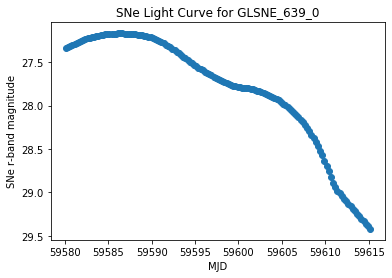

In [171]:
plt.scatter(im_0['time'], im_0_r_mags)
plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('SNe r-band magnitude')
plt.title('SNe Light Curve for %s' % im_0['obj_id'].iloc[0])

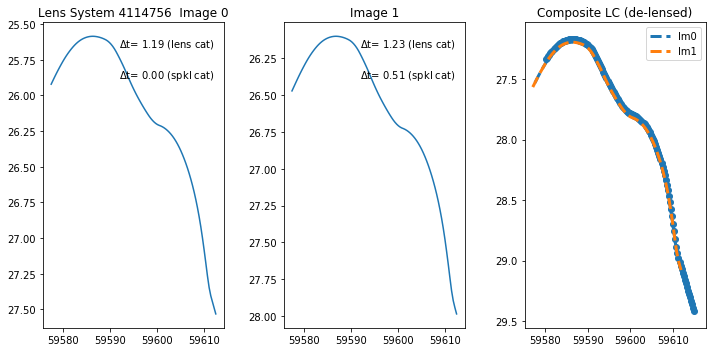

In [174]:
lens_sysid = 4114756
#lens_sysid = 6724378
lens_properties_catalog = sn_catalog_img
sprinkled_source_catalog = sprinkled_sne_df
plot_lensedSN_composite_lightcurve_model(lens_sysid, sprinkled_source_catalog, sn_catalog_img, plot_flux=False)
plt.scatter(im_0['time'], im_0_r_mags)
plt.tight_layout()